<a href="https://colab.research.google.com/github/chenyq121/760-2022S2/blob/main/optunaBaselineCNN_blur_2bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#mounted to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# os.chdir('/content/drive/Shareddrives/760/Data/')
# os.getcwd()
# os.listdir('.')

['image_Bored_Ape.zip',
 'Last_Sale_Price.csv',
 'price_cleaned.csv',
 'Bored_Ape_Dataset_Analysis.html',
 'ape',
 '1',
 '2',
 'temphold',
 'ape copy',
 'all_properties.csv',
 'test.txt',
 'validate.txt',
 'train.txt',
 'all_properties.gsheet',
 'price_cleaned_under200.csv',
 'u1.txt',
 'u2.txt',
 'test',
 'train',
 'u1',
 'u2',
 'utrain.txt',
 'uvalidate.txt',
 'utest.txt',
 'Trantimes.csv',
 'Tranaction.csv',
 'TransactionData.html',
 'price_cleaned_under200_log_label.numbers',
 'log-bin.gsheet',
 'log-bin.xlsx',
 'pricewlabel.csv',
 'cs760-model result track.xlsx',
 'ID-price-label.xlsx',
 'grey',
 'to_archive_760project data pre-process.ipynb']

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

NameError: ignored

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import os
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import optuna

# data processing 
class ClassifyDataset(torch.utils.data.Dataset):
    def __init__(self,root_path,data_file,img_size=120):
        self.data_files=np.loadtxt(data_file,dtype=np.str)
        self.root_path=root_path
        self.class_list=os.listdir(
            os.path.join(root_path,'')
        )
        self.transforms=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size,img_size)), 
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        data_file=self.data_files[item]
        data_file=os.path.join(self.root_path,data_file)
        # get the image
        img=Image.open(data_file).convert('RGB') # three channels
        # get the label(in this case the label is the folder name)
        tmp=data_file.split('/')
        label_name=tmp[-2]
        #print("label_name:",label_name)
        label=self.class_list.index(label_name)
        #print("label:",label)
        # prepare the images and label
        img=self.transforms(img)
        label=torch.tensor(label)
        #print("torch_label:",label)
        return img,label

    def __len__(self):
        return len(self.data_files)



# model building
class CNet(nn.Module):
    def __init__(self,num_classes=21, n_layer = 1, kernel_size = 1):
        super(CNet,self).__init__()
        self.convList = nn.ModuleList()

        for i in range(1, n_layer):
          input = 2 ** (i + 3)
          output = 2 ** (i + 4)
          if i == 1:
            input = 3
            
          self.convList.append(
              nn.Sequential(
                #input, output, kernel size, step, padding
                nn.Conv2d(input, output, kernel_size, 1, padding=1),
                nn.BatchNorm2d(output), # batch normalization
                nn.ReLU()
              )
          )

        self.pool = nn.AvgPool2d(2, 2)
        self.fclayer=nn.Sequential(
                nn.Linear(2 * input, 2 * output),
                nn.ReLU(),
                nn.Linear(2 * output, num_classes)
        )
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
      x = self.convList[0](x)
      x = self.pool(x)
      for conv in self.convList[1:]:
        x = conv(x)
        x = self.pool(x)
      x = self.avg_pool(x)
      x = torch.flatten(x,1)
      logits=self.fclayer(x)
      prob=self.softmax(logits)
      return logits,prob

    


# training
def training(model,root_path,train_data_file,batch_size,lr, epoch_num):
    # get training data
    train_dataset=ClassifyDataset(root_path,train_data_file)
    train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0)


    # loss function and optimizer
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    total_loss=[]

    for epoch in range(epoch_num):
        # print(epoch+1,"epoch:")
        total_train_loss=0
        res_num=len(train_dataset)
        for data in train_dataloader:

            if (res_num - batch_size) > 0:
                cnt=batch_size
                res_num = res_num - batch_size
            else:
                cnt=res_num
                res_num = 0

            ## GPU
            train_img,train_label=data
            train_img=train_img.to(device)
            train_label=train_label.to(device)

            ## get loss result
            train_logits,train_prob=model(train_img)
            train_loss=criterion.forward(train_logits,train_label)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_pred=torch.argmax(train_prob,dim=1)
            train_acc=(train_pred==train_label).float()
            train_acc=torch.mean(train_acc)
            # print('loss:',train_loss.item(), 'acc:', train_acc.item())
            total_train_loss=total_train_loss+train_loss*cnt

        total_train_loss=total_train_loss/len(train_dataset)
        total_loss.append(total_train_loss.item())

    state_dict=model.state_dict()
    torch.save(state_dict,'/content/drive/MyDrive/model/60-20-20model_blur2bin_120-optune.pth')

    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.plot(total_loss)
    # plt.legend(['train loss'])
    # plt.show()

# test
def test(model,root_path,test_data_file):
    state_dict = torch.load('/content/drive/MyDrive/model/60-20-20model_blur2bin_120-optune.pth')
    model.load_state_dict(state_dict)
    model.eval() # no BatchNormalization and Dropout

    test_dataset=ClassifyDataset(root_path,test_data_file)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    res_num=len(test_dataset)
    total_acc=0

    for data in test_dataloader:
      with torch.no_grad():

        if (res_num-batch_size)>0:
            cnt=batch_size
            res_num = res_num - batch_size
        else:
            cnt=res_num
            res_num = 0

        test_img,test_label=data
        test_img=test_img.to(device)
        test_label=test_label.to(device)

        test_logits,test_prob=model(test_img)
        test_loss=criterion.forward(test_logits,test_label)

        # Top1 accuracy: correct number/total number
        test_pred = torch.argmax(test_prob, dim=1)
        # print(test_pred)
        # print(test_label)
        test_acc = (test_pred == test_label).float()
        # print(test_acc)
        test_acc = torch.mean(test_acc)
        total_acc = total_acc + test_acc * cnt

        # print('loss:',test_loss.item(), 'top1:',test_acc.item() )

    total_acc=total_acc/len(test_dataset)
    return total_acc.item()
    # print('\n')
    # print('Top-1 Accuracy:',total_acc.item())


def objective(trial):

    params = {
              'n_layer': trial.suggest_int('n_layer', 3, 5, step = 2),
              'kernel_size': trial.suggest_int('kernel_size', 3, 5, step = 2),
              'lr': trial.suggest_categorical('lr', [0.1, 0.01, 0.001]),
              'epoch_num': trial.suggest_categorical('epoch_num', [10, 50, 100])
              }

    # get model and put model on the device
    model=CNet(n_layer = params['n_layer'], kernel_size = params['kernel_size'])
    model = model.to(device)

    training(model,root_path,train_data_file,batch_size,lr = params['lr'], epoch_num = params['epoch_num'])
    # torch.cuda.empty_cache()
    return test(model,root_path,test_data_file)




In [ ]:
# optuna hyperparameter tuning
if __name__ == '__main__':

    root_path = r'/content/drive/MyDrive/blur/'
    train_data_file=r'/content/drive/MyDrive/blur/2bintrain.txt'
    test_data_file=r'/content/drive/MyDrive/blur/2binvalidate.txt'
    batch_size=64
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    device = torch.device("cuda:0")
    
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=40)

[I 2022-09-28 22:05:42,735] A new study created in memory with name: no-name-a1dff2b1-2948-4c01-a657-8a37b944dd72
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
[I 2022-09-28 23:28:02,746] Trial 0 finished with value: 0.5207977294921875 and parameters: {'n_layer': 5, 'kernel_size': 5, 'lr': 0.01, 'epoch_num': 50}. Best is trial 0 with value: 0.5207977294921875.
[I 2022-09-29 00:13:53,352] Trial 1 finished with value: 0.4792022705078125 and parameters: {'n_layer': 3, 'kernel_size': 5, 'lr': 0.1, 'epoch_num': 50}. Best is trial 0 with value: 0.5207977294921875.
[I 2022-09

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))


In [ ]:
optuna.visualization.plot_optimization_history(study)

NameError: ignored

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import os
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import optuna

# data processing 
class ClassifyDataset(torch.utils.data.Dataset):
    def __init__(self,root_path,data_file,img_size=120):
        self.data_files=np.loadtxt(data_file,dtype=np.str)
        self.root_path=root_path
        self.class_list=os.listdir(
            os.path.join(root_path,'')
        )
        self.transforms=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size,img_size)), 
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        data_file=self.data_files[item]
        data_file=os.path.join(self.root_path,data_file)
        # get the image
        img=Image.open(data_file).convert('RGB') # three channels
        # get the label(in this case the label is the folder name)
        tmp=data_file.split('/')
        label_name=tmp[-2]
        #print("label_name:",label_name)
        label=self.class_list.index(label_name)
        #print("label:",label)
        # prepare the images and label
        img=self.transforms(img)
        label=torch.tensor(label)
        #print("torch_label:",label)
        return img,label

    def __len__(self):
        return len(self.data_files)



# model building
class CNet(nn.Module):
    def __init__(self,num_classes=21, n_layer = 1, kernel_size = 1):
        super(CNet,self).__init__()
        self.convList = nn.ModuleList()

        for i in range(1, n_layer):
          input = 2 ** (i + 3)
          output = 2 ** (i + 4)
          if i == 1:
            input = 3
            
          self.convList.append(
              nn.Sequential(
                #input, output, kernel size, step, padding
                nn.Conv2d(input, output, kernel_size, 1, padding=1),
                nn.BatchNorm2d(output), # batch normalization
                nn.ReLU()
              )
          )

        self.pool = nn.AvgPool2d(2, 2)
        self.fclayer=nn.Sequential(
                nn.Linear(2 * input, 2 * output),
                nn.ReLU(),
                nn.Linear(2 * output, num_classes)
        )
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
      x = self.convList[0](x)
      x = self.pool(x)
      for conv in self.convList[1:]:
        x = conv(x)
        x = self.pool(x)
      x = self.avg_pool(x)
      x = torch.flatten(x,1)
      logits=self.fclayer(x)
      prob=self.softmax(logits)
      return logits,prob

    


# training
def training(model,root_path,train_data_file,batch_size,lr, epoch_num):
    # get training data
    train_dataset=ClassifyDataset(root_path,train_data_file)
    train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0)


    # loss function and optimizer
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    total_loss=[]

    for epoch in range(epoch_num):
        print(epoch+1,"epoch:")
        total_train_loss=0
        res_num=len(train_dataset)
        for data in train_dataloader:

            if (res_num - batch_size) > 0:
                cnt=batch_size
                res_num = res_num - batch_size
            else:
                cnt=res_num
                res_num = 0

            ## GPU
            train_img,train_label=data
            train_img=train_img.to(device)
            train_label=train_label.to(device)

            ## get loss result
            train_logits,train_prob=model(train_img)
            train_loss=criterion.forward(train_logits,train_label)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_pred=torch.argmax(train_prob,dim=1)
            train_acc=(train_pred==train_label).float()
            train_acc=torch.mean(train_acc)
            # print('loss:',train_loss.item(), 'acc:', train_acc.item())
            total_train_loss=total_train_loss+train_loss*cnt

        total_train_loss=total_train_loss/len(train_dataset)
        total_loss.append(total_train_loss.item())

    state_dict=model.state_dict()
    torch.save(state_dict,'/content/drive/MyDrive/model/60-20-20model_grey2bin_120-optune.pth')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(total_loss)
    plt.legend(['train loss'])
    plt.show()

# test
def test(model,root_path,test_data_file):
    state_dict = torch.load('/content/drive/MyDrive/model/60-20-20model_grey2bin_120-optune.pth')
    model.load_state_dict(state_dict)
    model.eval() # no BatchNormalization and Dropout

    test_dataset=ClassifyDataset(root_path,test_data_file)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    res_num=len(test_dataset)
    total_acc=0

    for data in test_dataloader:
      with torch.no_grad():

        if (res_num-batch_size)>0:
            cnt=batch_size
            res_num = res_num - batch_size
        else:
            cnt=res_num
            res_num = 0

        test_img,test_label=data
        test_img=test_img.to(device)
        test_label=test_label.to(device)

        test_logits,test_prob=model(test_img)
        test_loss=criterion.forward(test_logits,test_label)

        # Top1 accuracy: correct number/total number
        test_pred = torch.argmax(test_prob, dim=1)
        # print(test_pred)
        # print(test_label)
        test_acc = (test_pred == test_label).float()
        # print(test_acc)
        test_acc = torch.mean(test_acc)
        total_acc = total_acc + test_acc * cnt

        print('loss:',test_loss.item(), 'top1:',test_acc.item() )

    total_acc=total_acc/len(test_dataset)
    # return total_acc.item()
    print('\n')
    print('Top-1 Accuracy:',total_acc.item())


# def objective(trial):

#     params = {
#               'n_layer': trial.suggest_int('n_layer', 3, 5, step = 2),
#               'kernel_size': trial.suggest_int('kernel_size', 3, 5, step = 2),
#               'lr': trial.suggest_categorical('lr', [0.1, 0.01, 0.001]),
#               'epoch_num': trial.suggest_categorical('epoch_num', [10, 50, 100])
#               }

#     # get model and put model on the device
#     model=CNet(n_layer = params['n_layer'], kernel_size = params['kernel_size'])
#     model = model.to(device)

#     training(model,root_path,train_data_file,batch_size,lr = params['lr'], epoch_num = params['epoch_num'])
#     # torch.cuda.empty_cache()
#     return test(model,root_path,test_data_file)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


Streaming output truncated to the last 5000 lines.
loss: 2.090175151824951 acc: 0.203125
loss: 2.0603489875793457 acc: 0.15625
loss: 2.054953098297119 acc: 0.171875
loss: 2.030704975128174 acc: 0.203125
loss: 2.0503435134887695 acc: 0.1860465109348297
56 epoch:
loss: 2.058945417404175 acc: 0.171875
loss: 2.0855653285980225 acc: 0.140625
loss: 2.0699968338012695 acc: 0.140625
loss: 2.062981367111206 acc: 0.15625
loss: 2.0892908573150635 acc: 0.078125
loss: 2.014535903930664 acc: 0.203125
loss: 2.0951430797576904 acc: 0.140625
loss: 2.0749154090881348 acc: 0.15625
loss: 2.0650835037231445 acc: 0.171875
loss: 2.013392210006714 acc: 0.21875
loss: 2.0568532943725586 acc: 0.109375
loss: 2.0539324283599854 acc: 0.109375
loss: 2.0747549533843994 acc: 0.140625
loss: 2.041456699371338 acc: 0.15625
loss: 2.091939687728882 acc: 0.109375
loss: 2.1047286987304688 acc: 0.078125
loss: 2.048380136489868 acc: 0.234375
loss: 2.0555310249328613 acc: 0.15625
loss: 2.1041696071624756 acc: 0.1875
loss: 2.054

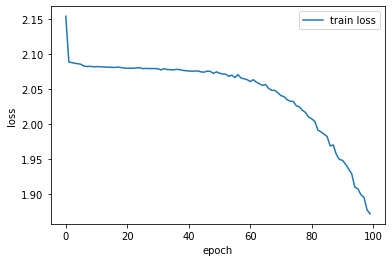

loss: 2.2148420810699463 top1: 0.09375
loss: 2.3595287799835205 top1: 0.140625
loss: 2.1996958255767822 top1: 0.203125
loss: 2.3099417686462402 top1: 0.109375
loss: 2.187011957168579 top1: 0.078125
loss: 2.1475861072540283 top1: 0.234375
loss: 2.366140604019165 top1: 0.09375
loss: 2.175977945327759 top1: 0.1875
loss: 2.1622865200042725 top1: 0.171875
loss: 2.2420008182525635 top1: 0.046875
loss: 2.333207368850708 top1: 0.078125
loss: 2.185371160507202 top1: 0.140625
loss: 2.204240560531616 top1: 0.171875
loss: 2.189215898513794 top1: 0.21875
loss: 2.361299753189087 top1: 0.09375
loss: 2.1898486614227295 top1: 0.203125
loss: 2.391968011856079 top1: 0.09375
loss: 2.139730930328369 top1: 0.15625
loss: 2.2002902030944824 top1: 0.15625
loss: 2.3006110191345215 top1: 0.09375
loss: 2.217603921890259 top1: 0.09375
loss: 2.3263492584228516 top1: 0.09375
loss: 2.380478858947754 top1: 0.109375
loss: 2.2862842082977295 top1: 0.078125
loss: 2.2620766162872314 top1: 0.140625
loss: 2.2191991806030273

In [ ]:
# main function
if __name__ == '__main__':

    root_path = r'/content/drive/MyDrive/grey/'
    train_data_file=r'/content/drive/MyDrive/grey/2bintrainval.txt'
    test_data_file=r'/content/drive/MyDrive/grey/2bintest.txt'
    batch_size=64
    lr=best_trial.params['lr'] #learning rate
    epoch_num=best_trial.params['epoch_num']
    layers=best_trial.params['n_layer']
    kernals=best_trial.params['kernel_size']
    # lr=0.01 #learning rate
    # epoch_num=100
    # layers=5
    # kernals=5
    device='cuda:0'
    # get model and put model on the device
    model=CNet(n_layer = layers, kernel_size = kernals)
    model.to(device)

    training(model,root_path,train_data_file,batch_size,lr,epoch_num)
    torch.cuda.empty_cache()
    test(model,root_path,test_data_file)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
